   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


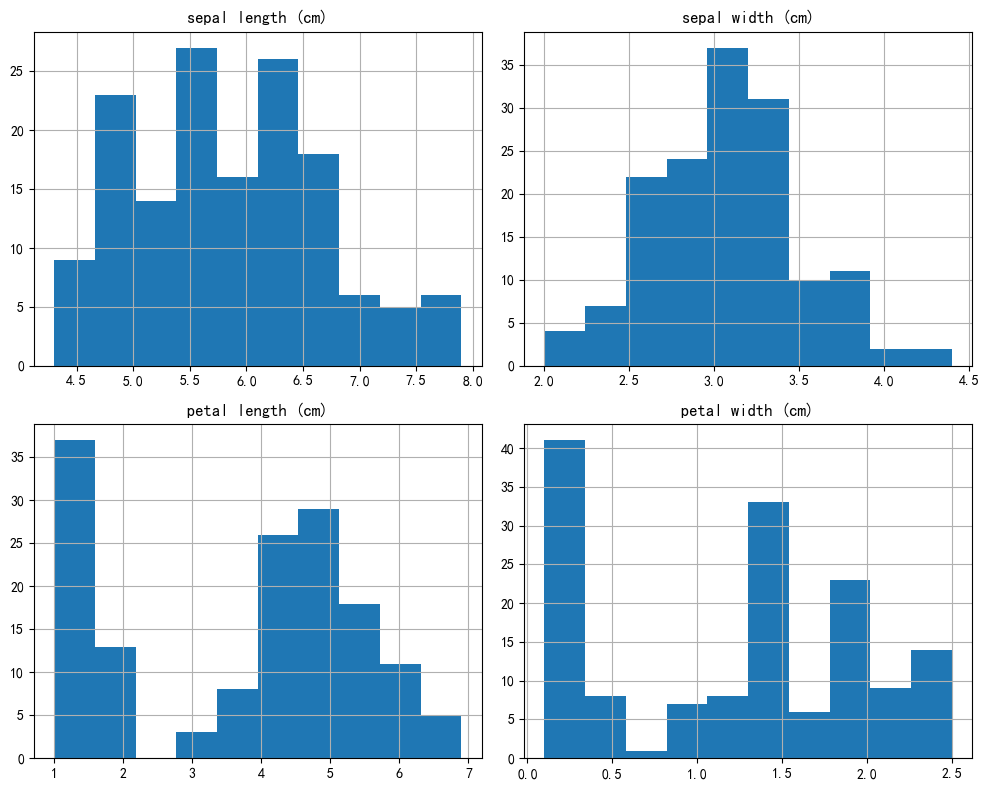

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# 1. 读取数据
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

df = pd.DataFrame(X, columns=iris_data.feature_names)
print(df.head())

# 2. 数据可视化
# 4种特征维度分布情况直方图
print("\n正在生成特征分布直方图...")
df.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [ ]:
# 1. 数据划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2. 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. 格式转换 (Numpy -> Tensor)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# 4. 创建 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

print("数据预处理完成。")
print(f"训练集形状: {X_train_tensor.shape}")
print(f"测试集形状: {X_test_tensor.shape}")

训练集形状: torch.Size([105, 4])
测试集形状: torch.Size([45, 4])


In [ ]:
# 定义多层感知机模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# 设置模型参数
input_size = X_train.shape[1]  # 4个特征
hidden_size = 16               # 隐藏层神经元数量
num_classes = 3                # 3类鸢尾花

# 实例化模型
model = MLP(input_size, hidden_size, num_classes)
print(model)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

MLP(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)


In [ ]:
# 训练模型
num_epochs = 50
loss_history = []

print("开始训练...")
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# 测试集预测
model.eval() # 切换到评估模式
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test, predicted)

print(f'\nAccuracy on test set: {accuracy * 100:.2f}%')

Epoch [10/50], Loss: 0.1240
Epoch [20/50], Loss: 0.0521
Epoch [30/50], Loss: 0.0240
Epoch [40/50], Loss: 0.0769
Epoch [50/50], Loss: 0.0021

Accuracy on test set: 100.00%


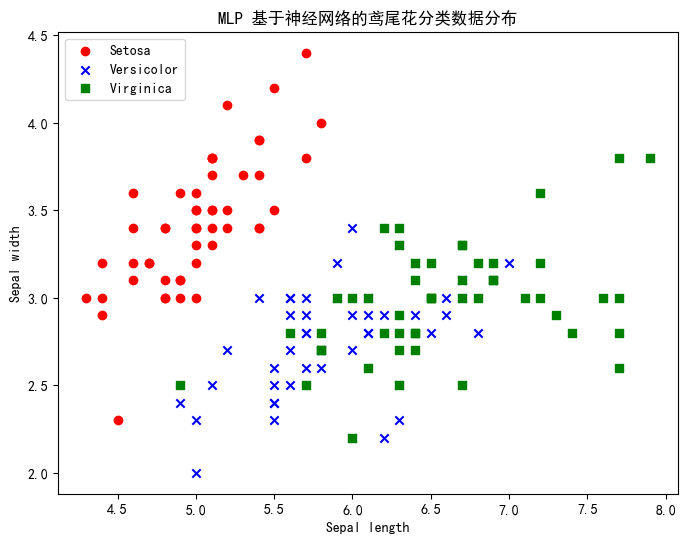

In [6]:
# 绘图
# 注意：这里使用的是原始数据的特征的前两维进行绘图，仅作为分布展示
# 因为进行了标准化，为了可视化原始意义，我们使用原始的 X 数据（未标准化前）进行绘图逻辑
# 但 PDF 中直接使用了 X切片，我们尽量还原 PDF 逻辑。
# PDF 逻辑是直接取 X[:50, 0] 等，这假设 X 是按类别排序的。
# 原始 load_iris 确实是排序的，但我们在 3.2 中做了 train_test_split 打乱了顺序。
# 为了完全复现 PDF 的图（展示原始数据分布），我们重新调用原始数据 X 进行绘图。

plt.figure(figsize=(8, 6))
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='Versicolor')
plt.scatter(X[100:, 0], X[100:, 1], color='green', marker='s', label='Virginica')

plt.title("MLP 基于神经网络的鸢尾花分类数据分布")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.legend(loc=2)
plt.show()

In [ ]:
def train_evaluate_mlp(h_size, lr_rate):
    # 重新实例化模型
    temp_model = MLP(input_size, h_size, num_classes)
    temp_optim = optim.Adam(temp_model.parameters(), lr=lr_rate)
    
    # 简单训练 50 epoch
    for epoch in range(50):
        for inputs, labels in train_loader:
            out = temp_model(inputs)
            loss = criterion(out, labels)
            temp_optim.zero_grad()
            loss.backward()
            temp_optim.step()
    
    # 评估
    temp_model.eval()
    with torch.no_grad():
        out = temp_model(X_test_tensor)
        _, pred = torch.max(out, 1)
        acc = accuracy_score(y_test, pred)
    return acc

# 对比不同参数
params = [
    (16, 0.01),   # 原始参数
    (4, 0.01),    # 减少神经元
    (64, 0.01),   # 增加神经元
    (16, 0.001)   # 减小学习率
]

for h, l in params:
    acc = train_evaluate_mlp(h, l)
    print(f"Hidden Size: {h}, LR: {l} -> Accuracy: {acc*100:.2f}%")

Hidden Size: 16, LR: 0.01 -> Accuracy: 100.00%
Hidden Size: 4, LR: 0.01 -> Accuracy: 97.78%
Hidden Size: 64, LR: 0.01 -> Accuracy: 100.00%
Hidden Size: 16, LR: 0.001 -> Accuracy: 86.67%


In [ ]:
from sklearn.datasets import load_digits

# 1. 加载数据
digits = load_digits()
X_dig = digits.data
y_dig = digits.target

print(f"Digits 数据集形状: {X_dig.shape} (1797个样本, 64个特征)")
print(f"类别数量: {len(np.unique(y_dig))} (0-9)")

# 2. 划分与标准化
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dig, y_dig, test_size=0.3, random_state=42)
scaler_d = StandardScaler()
X_train_d = scaler_d.fit_transform(X_train_d)
X_test_d = scaler_d.transform(X_test_d)

# 3. 转 Tensor
X_train_d_t = torch.tensor(X_train_d, dtype=torch.float32)
y_train_d_t = torch.tensor(y_train_d, dtype=torch.long)
X_test_d_t = torch.tensor(X_test_d, dtype=torch.float32)
y_test_d_t = torch.tensor(y_test_d, dtype=torch.long)

train_loader_d = DataLoader(TensorDataset(X_train_d_t, y_train_d_t), batch_size=32, shuffle=True)

# 4. 定义模型
input_dim_d = 64
hidden_dim_d = 64 # 增加一些隐藏层神经元
output_dim_d = 10

model_digits = MLP(input_dim_d, hidden_dim_d, output_dim_d)
opt_d = optim.Adam(model_digits.parameters(), lr=0.001) # 学习率调小一点防止震荡

# 5. 训练
print("开始训练 Digits 模型")
for epoch in range(50):
    for x_batch, y_batch in train_loader_d:
        out = model_digits(x_batch)
        loss = criterion(out, y_batch)
        opt_d.zero_grad()
        loss.backward()
        opt_d.step()

# 6. 评估
model_digits.eval()
with torch.no_grad():
    test_out = model_digits(X_test_d_t)
    _, pred_d = torch.max(test_out, 1)
    acc_d = accuracy_score(y_test_d, pred_d)

print(f"Digits 手写数字识别准确率: {acc_d * 100:.2f}%")

Digits 数据集形状: (1797, 64) (1797个样本, 64个特征)
类别数量: 10 (0-9)
开始训练 Digits 模型
Digits 手写数字识别准确率: 97.96%
